In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns


sns.set()

In [2]:
words = open('names.txt','r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

## Splitting dataset into training,test & validation

In [21]:
def build_dataset(words:list):
    '''Seperates the data into training, test and validation'''
    block_size = 3 # Context Length: How many characters we take as input to predict the output 
    X,Y = [],[]
    
    for w in words:
        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '---->', itos[ix])
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X,Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,Ytr = build_dataset(words[:n1])
Xdev,Ydev = build_dataset(words[n1:n2])
Xte,Yte = build_dataset(words[n2:])

In [23]:
print(f'Training examples shapes: {Xtr.shape},{Ytr.shape}')
print(f'Validation examples shapes: {Xdev.shape},{Ydev.shape}')
print(f'Testing examples shapes: {Xte.shape},{Yte.shape}')


Training examples shapes: torch.Size([182625, 3]),torch.Size([182625])
Validation examples shapes: torch.Size([22655, 3]),torch.Size([22655])
Testing examples shapes: torch.Size([22866, 3]),torch.Size([22866])


### Practice

In [30]:
C = torch.randn((27,2)) # This is the embedding matrix

In [32]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [38]:
W1 = torch.randn((6,100))
b1 = torch.randn(100)

In [52]:
h = torch.tanh(emb.view(-1,6)@W1 + b1)

In [50]:
h.shape

torch.Size([32, 100])

In [76]:
W2 = torch.randn((100,27))
b2 = torch.randn(27)

In [78]:
logits = h @ W2 + b2

In [80]:
logits.shape

torch.Size([32, 27])

In [82]:
counts = logits.exp()
probs = counts / counts.sum(1,keepdims = True)

In [86]:
probs.shape

torch.Size([32, 27])

In [101]:
loss = -probs[torch.arange(32),Y].log().mean()
loss

tensor(16.8305)

### Better written code

In [13]:
embed_size = 10 # Context length (The dimensionality of the character embedding vector)
n_hidden = 200 # Number of neurons in the hidden layer
vocab_size = 27
block_size = Xtr.shape[1]
g = torch.Generator().manual_seed(2185)
C = torch.randn((vocab_size,embed_size),generator = g)
W1 = torch.randn((embed_size * block_size,n_hidden),generator = g) * 0.01
b1 = torch.randn(n_hidden,generator = g) * 0.01
W2 = torch.randn((n_hidden,vocab_size),generator = g) * 0.01
b2 = torch.randn(vocab_size,generator = g) * 0
parameters = [C,W1,b1,W2,b2]

In [15]:
for p in parameters:
    p.requires_grad = True

In [17]:
sum(p.nelement() for p in parameters)

11897

In [19]:
losses = []
epochs = 1000
for i in range(epochs):
    # Forward pass
    emb = C[Xtr]
    h = torch.tanh(emb.view(-1,30)@W1 + b1)
    logits = h@W2 + b2
    loss = F.cross_entropy(logits,Ytr) 
    # BackPropogation
    for p in parameters:
        p.grad = None
    loss.backward()
    # Weight Updates
    for p in parameters:
        p.data -= 0.01 * p.grad
    losses.append(loss.data.item())
plt.plot(torch.arange(epochs),losses)
plt.title(losses[-1])

KeyboardInterrupt: 

In [24]:
def train_gradientDescent(X:torch.tensor,y:torch.tensor,epochs: int):
    '''Training the model using the gradient descent'''
    losses = []
    for i in range(epochs):
        emb = C[X]
        embcat = emb.view(emb.shape[0],-1)
        h = torch.tanh(embcat@W1 + b1)
        logits = h @ W2 + b2
        loss = F.cross_entropy(logits,y)
        if(i % 10000) == 0:
            print(f'{i}/{epochs} -> {loss}')
        losses.append(loss)
        for p in parameters:
            p.grad = None
        loss.backward()
        lr = 0.1 if i < epochs //2 else 0.01
        for p in parameters:
            p.data -= lr * p.grad

train_gradientDescent(Xtr,Ytr,10)

0/10 -> 2.3564460277557373


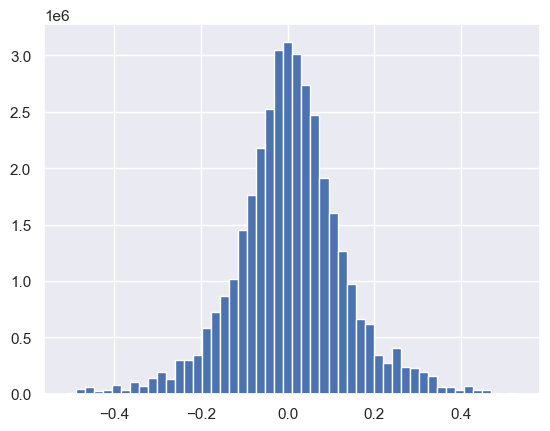

In [26]:
plt.hist(h.view(-1).tolist(),50);

### Evaluation of the model

In [347]:
@torch.no_grad()
def evalModel(X:torch.tensor,Y:torch.tensor):
    '''Evaluates the performance of the model on the validation set'''
    emb = C[X]
    h = torch.tanh(emb.view(-1,30)@W1 + b1)
    logits = h@W2 + b2
    loss = F.cross_entropy(logits,Y)
    print(f'Loss -> {loss}')

evalModel(Xdev,Ydev)

Loss -> 2.1865592002868652


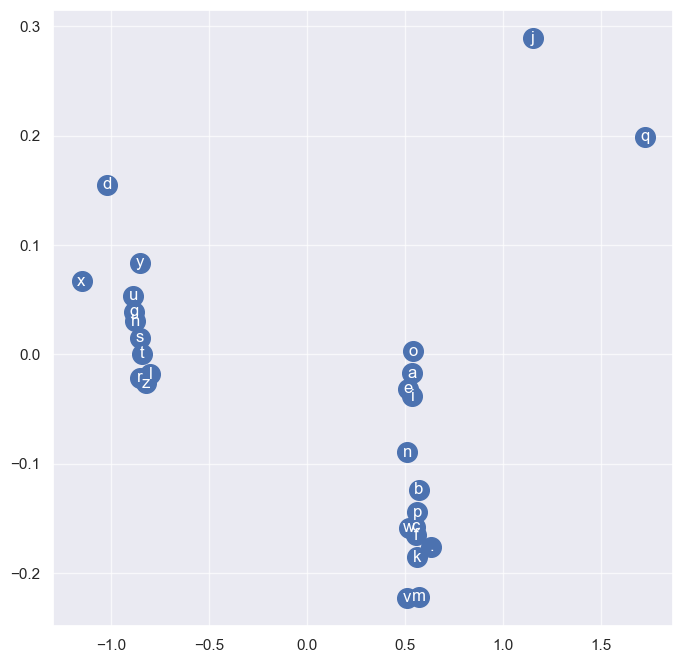

In [276]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data,C[:,1].data,s = 200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(),C[i,1].item(),itos[i],ha = 'center',va = 'center', color = 'white')
plt.grid(alpha = 0.7)

### Mini-batch Gradient Descent

In [379]:
# for p in parameters:
#     p.grad = None
# for _ in range(100):
#     ix = torch.randint(0,X.shape[0],(32,)) # Selecting 32 random entries from the input for the mini-batch
#     emb = C[X[ix]]
#     h = torch.tanh(emb.view(-1,)@W1 + b1)
#     logits = h@W2 + b2
#     loss = F.cross_entropy(logits,Y[ix]) 
#     # BackPropogation
#     for p in parameters:
#         p.grad = None
#     loss.backward()
#     # Weight Updatesa
#     for p in parameters:
#         p.data -= 0.1 * p.grad
#     print(loss.data.item())

In [389]:
def train_minibatch(X:torch.tensor, y:torch.tensor,epochs: int):
    losses = []
    '''Mini-Batch Gradient Descent'''
    for p in parameters:
        p.grad = None
    for i in range(epochs):
        ix = torch.randint(0,X.shape[0],(32,))
        emb = C[X[ix]]
        embcat = emb.view(emb.shape[0],-1)
        h = torch.tanh(embcat@W1 + b1)
        logits = h @ W2 + b2
        loss = F.cross_entropy(logits,y[ix])
        if(i % 10000) == 0:
            print(f'{i}/{epochs} -> {loss}')
        losses.append(loss)
        for p in parameters:
            p.grad = None
        loss.backward()
        lr = 0.1 if i < epochs //2 else 0.01
        for p in parameters:
            p.data -= lr * p.grad

In [391]:
train_minibatch(Xtr,Ytr,100000)

0/100000 -> 2.390184164047241
10000/100000 -> 2.2557294368743896
20000/100000 -> 1.9033842086791992
30000/100000 -> 2.4155831336975098
40000/100000 -> 2.0174362659454346
50000/100000 -> 1.7248660326004028
60000/100000 -> 2.1274495124816895
70000/100000 -> 2.1045427322387695
80000/100000 -> 2.021770715713501
90000/100000 -> 1.8380399942398071


In [392]:
evalModel(Xdev,Ydev)

Loss -> 2.1444594860076904


In [397]:
h.view(-1).shape

torch.Size([36487400])

# Writing the same code using `PyTorch`

In [25]:
class Linear:
    def __init__(self,fan_in:int,fan_out:int,bias:bool = True):
        self.weight = torch.randn((fan_in,fan_out),generator = g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias is True else None

    def __call__(self,x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

In [27]:
class BatchNormalization:
    def __init__(self,dim,eps = 1e-5, momentum = 0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        # Parameters: Trained during Back-Propogation
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        # Parameters: Updated using running mean and std
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self,x):
        # Calculate the forward pass
        if self.training:
            xmean = x.mean(0,keepdim = True)
            xvar = x.var(0, keepdim = True, unbiased = True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # Normalization to unit variance
        self.out = self.gamma * xhat + self.beta

        # Updating the running mean and variance
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma , self.beta]

In [29]:
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

In [31]:
n_embed = 10
n_hidden = 100
g = torch.Generator().manual_seed(21644343223)
block_size = 3
vocab_size = 27
C = torch.randn((vocab_size,n_embed), generator = g)
layers = [
    Linear(n_embed*block_size,n_hidden),
    BatchNormalization(n_hidden),
    Tanh(),
    Linear(n_hidden,n_hidden),
    BatchNormalization(n_hidden),
    Tanh(),
    Linear(n_hidden,n_hidden),
    BatchNormalization(n_hidden),
    Tanh(),
    Linear(n_hidden,n_hidden),
    BatchNormalization(n_hidden),
    Tanh(),
    Linear(n_hidden,n_hidden),
    BatchNormalization(n_hidden),
    Tanh(),
    Linear(n_hidden,vocab_size),
    BatchNormalization(vocab_size),
]

with torch.no_grad():
    layers[-1].gamma *=  0.1
    for layer in layers[:-1]:
        if isinstance(layer,Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in  parameters))

for p in parameters:
    p.requires_grad = True

47551


In [33]:
batch_size = 32
max_steps = 200000
losses = []

for i in range(max_steps):
    # Mini-batch construct
    ix = torch.randint(0,Xtr.shape[0],(batch_size, ), generator = g)
    Xb,yb = Xtr[ix],Ytr[ix]

    # ----- FORWARD PASS ----- #
    emb = C[Xb] # Embed the characters into vectors
    x = emb.view(emb.shape[0],-1) # Reshape the embedding vector into 2-dimensional matrix
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x,yb) # Categorical Cross-Entropy as the loss function

    # ----- BACKWARD PASS ----- #
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    # ----- UPDATE ----- #
    lr = 0.1 if i < (max_steps // 2) else 0.01
    for p in parameters:
        p.data -= lr * p.grad

    # ----- PRINTING LOSS ----- #
    if (i % 10000 == 0):
        print(f'{i}/{max_steps} -> {loss.item()}')
    losses.append(loss.log10().item())
    break

0/200000 -> 3.311858892440796


layer 2 (      Tanh): mean +0.00, std 0.62, saturated 3.66%
layer 5 (      Tanh): mean +0.00, std 0.63, saturated 2.84%
layer 8 (      Tanh): mean -0.01, std 0.63, saturated 2.81%
layer 11 (      Tanh): mean +0.00, std 0.64, saturated 2.59%
layer 14 (      Tanh): mean -0.00, std 0.64, saturated 2.56%


Text(0.5, 1.0, 'Activation distribution')

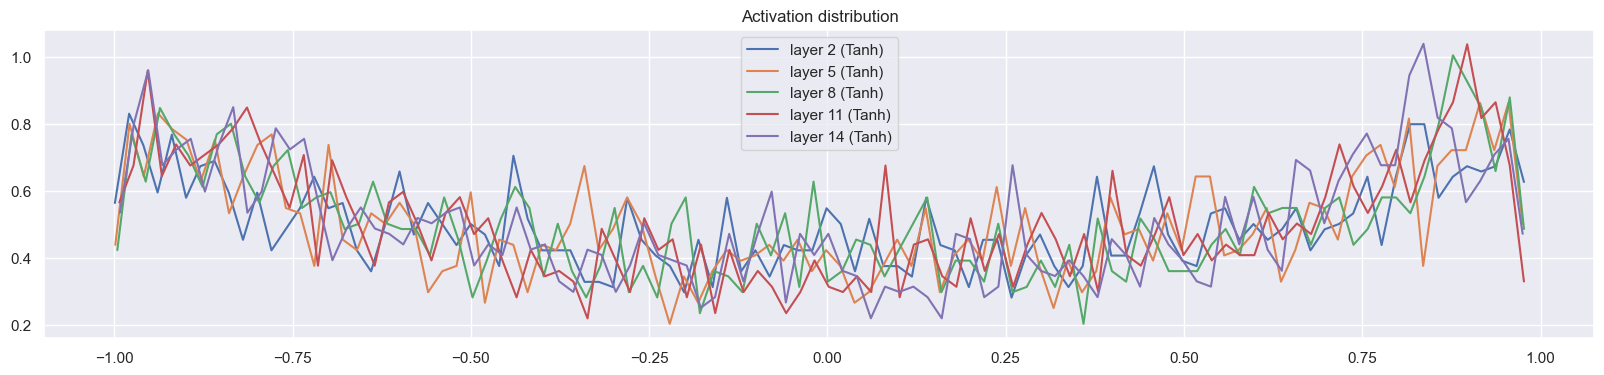

In [35]:
# Activation Visualization - FORWARD PASS

plt.figure(figsize=(20,4))
legends = []
for i,layer in enumerate(layers[:-1]):
    if isinstance(layer,Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(),(t.abs() > 0.97).float().mean()*100))
        hy,hx = torch.histogram(t, density = True)
        plt.plot(hx[:-1].detach(),hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title("Activation distribution")

layer 2 (      Tanh): mean -0.00, std 0.00, saturated 0.00%
layer 5 (      Tanh): mean -0.00, std 0.00, saturated 0.00%
layer 8 (      Tanh): mean -0.00, std 0.00, saturated 0.00%
layer 11 (      Tanh): mean -0.00, std 0.00, saturated 0.00%
layer 14 (      Tanh): mean -0.00, std 0.00, saturated 0.00%


Text(0.5, 1.0, 'Activation distribution')

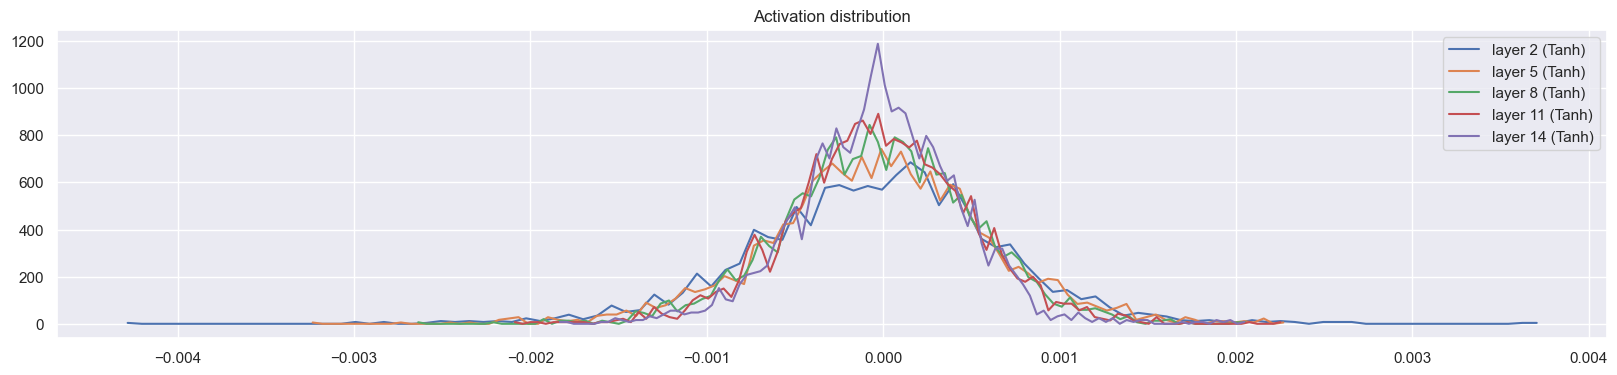

In [37]:
# Activation Visualization - FORWARD PASS

plt.figure(figsize=(20,4))
legends = []
for i,layer in enumerate(layers[:-1]):
    if isinstance(layer,Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(),(t.abs() > 0.97).float().mean()*100))
        hy,hx = torch.histogram(t, density = True)
        plt.plot(hx[:-1].detach(),hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title("Activation distribution")